# To Replicate Test:
Create an empty (containing only "{}") json file at the path *atmo_chem\\NASAcomparison.json*. Run the command 

`jupyter nbconvert --to notebook --execute --inplace --allow-errors atmo_chem.ipynb`

in terminal 50 times (in a loop, for example). This will populate *atmo_chem\\NASAcomparison.json* with the results for each of the 50 stations. These data are visualized in *figures.ipynb*.

Make sure the data is located at *atmo_chem\\stations\\* and follows the naming convention: observed data files start with "obs_" and NASA model forecasts start with "model_forecast_".

In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

from scipy.stats import norm, skewnorm, gamma
%load_ext autoreload
%autoreload 2

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import GammaNLL, SkewNormalNLL

In [4]:
def pinball_loss(data, quant_preds, quantiles):
    assert(len(data) == len(quant_preds))
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
def nmb(data, pred):
    """Normalized mean bias"""
    assert(len(data) == len(pred))
    return np.mean(pred - data) / np.mean(data)

def nrmse(data, pred):
    """Normalized root mean square error"""
    assert(len(data) == len(pred))
    sorted_data = sorted(data)
    o05 = sorted_data[int(len(data) * 0.05)]
    o95 = sorted_data[int(len(data) * 0.95)]
    return np.sqrt(np.mean((data - pred)**2)) / (o95 - o05)

from scipy.stats import pearsonr
def correlation(data, pred):
    """Pearson correlation"""
    assert(len(data) == len(pred))
    return pearsonr(data, pred)[0]    

In [6]:
import json
with open(".\\atmo_chem\\NASAcomparison.json") as f:
    NASAcomparison = json.loads(f.read())
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

In [7]:
station_path = ".\\atmo_chem\\stations\\"
for fname in os.listdir(station_path):
    if fname.startswith("obs_") and fname[len("obs_"):-len(".csv")] not in NASAcomparison.keys():
        station_name = fname[len("obs_"):-len(".csv")]
        break
station_name

'JPN_Tokyo_13117520'

In [8]:
NASAcomparison[station_name] = dict()

obsfile = os.path.join(station_path, 'obs_%s.csv'.replace('%s',station_name))
obs = pd.read_csv(obsfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
t_min = obs.t.min()
obs.t -= t_min
obs_no2 = obs.loc[obs.obstype=='no2']
obs_o3 = obs.loc[obs.obstype=='o3']
obs_pm25 = obs.loc[obs.obstype=='pm25']
 
modfile = os.path.join(station_path, 'model_forecast_%s.csv'.replace('%s',station_name))
mod = pd.read_csv(modfile, parse_dates=['ISO8601','ISO8601_init'],date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601_init','ISO8601'])
mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]
mod.t -= t_min

In [9]:
obs

,ISO8601,original_station_name,lat,lon,obstype,conc_obs,conc_obs.1,conc_unit,t
0,2018-01-01 01:00:00,JPN_Tokyo_13117520,35.68,139.69,no2,32.0,32.0,ppbv,0.0
1,2018-01-01 01:00:00,JPN_Tokyo_13117520,35.68,139.69,pm25,29.0,29.0,ugm-3,0.0
2,2018-01-01 02:00:00,JPN_Tokyo_13117520,35.68,139.69,pm25,32.0,32.0,ugm-3,3600.0
3,2018-01-01 02:00:00,JPN_Tokyo_13117520,35.68,139.69,no2,30.0,30.0,ppbv,3600.0
4,2018-01-01 03:00:00,JPN_Tokyo_13117520,35.68,139.69,no2,30.0,30.0,ppbv,7200.0
...,...,...,...,...,...,...,...,...,...
42631,2020-06-30 22:00:00,JPN_Tokyo_13117520,35.68,139.69,pm25,7.0,7.0,ugm-3,78782400.0
42632,2020-06-30 23:00:00,JPN_Tokyo_13117520,35.68,139.69,no2,3.0,3.0,ppbv,78786000.0
42633,2020-06-30 23:00:00,JPN_Tokyo_13117520,35.68,139.69,pm25,7.0,7.0,ugm-3,78786000.0
42634,2020-07-01 00:00:00,JPN_Tokyo_13117520,35.68,139.69,no2,3.0,3.0,ppbv,78789600.0


In [10]:
mod

,ISO8601_init,ISO8601,location,lat,lon,NO2,O3,PM25_RH35_GCC,t
0,2019-01-01,2019-01-01 12:30:00,JPN_Tokyo_13117520,35.68,139.69,4.138571e-08,1.190159e-13,37.328625,31577400.0
1,2019-01-01,2019-01-01 13:30:00,JPN_Tokyo_13117520,35.68,139.69,4.330656e-08,2.908784e-14,44.753418,31581000.0
2,2019-01-01,2019-01-01 14:30:00,JPN_Tokyo_13117520,35.68,139.69,4.784675e-08,3.068656e-13,47.063950,31584600.0
3,2019-01-01,2019-01-01 15:30:00,JPN_Tokyo_13117520,35.68,139.69,5.230589e-08,1.816147e-11,38.564743,31588200.0
4,2019-01-01,2019-01-01 16:30:00,JPN_Tokyo_13117520,35.68,139.69,4.953476e-08,2.266915e-10,29.075287,31591800.0
...,...,...,...,...,...,...,...,...,...
43550,2019-12-31,2020-01-05 07:30:00,JPN_Tokyo_13117520,35.68,139.69,1.688026e-08,2.092582e-08,6.556013,63441000.0
43551,2019-12-31,2020-01-05 08:30:00,JPN_Tokyo_13117520,35.68,139.69,2.174060e-08,1.635699e-08,6.911601,63444600.0
43552,2019-12-31,2020-01-05 09:30:00,JPN_Tokyo_13117520,35.68,139.69,2.619348e-08,1.196168e-08,7.715721,63448200.0
43553,2019-12-31,2020-01-05 10:30:00,JPN_Tokyo_13117520,35.68,139.69,2.901655e-08,9.167707e-09,8.507068,63451800.0


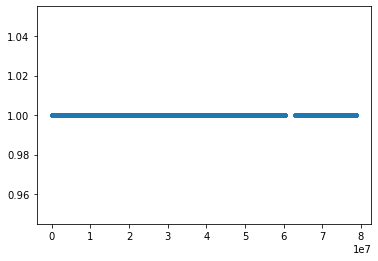

In [11]:
plt.figure()
plt.plot(obs.t, np.ones(len(obs.t)), ".")

In [12]:
diff = -(pd.to_datetime(mod.ISO8601_init) - pd.to_datetime(mod.ISO8601))
five_day_mod = mod[(diff > dt.timedelta(days=4)) & (diff < dt.timedelta(days=5))]
mods = dict()
for num_ahead in range(1, 6):
    mods[f"ahead{num_ahead}"] = mod[(diff > dt.timedelta(days=num_ahead - 0.5)) & (diff < dt.timedelta(days=num_ahead + 0.5))]

In [13]:
mods_no2 = [mods[x].NO2.values[:8707] for x in mods.keys()]
mods_no2 = np.array(mods_no2).T
mods_o3 = [mods[x].O3.values[:8707] for x in mods.keys()]
mods_o3 = np.array(mods_o3).T
mods_pm25 = [mods[x].PM25_RH35_GCC.values[:8707] for x in mods.keys()]
mods_pm25 = np.array(mods_pm25).T

In [14]:
mods_no2.shape,mods_o3.shape,mods_pm25.shape,

((8707, 5), (8707, 5), (8707, 5))

In [15]:
chemical = "NO2"
x = np.expand_dims(obs_no2.conc_obs.values, -1)
t = obs_no2.t.values
print("x", x.shape)
print("t", t.shape)

x (21193, 1)
t (21193,)


for flu data/integer data, use smooth parameter, discrete probability dist
NO2, O3, NO, HNO4, ISOP, N2O5, NIT, PRPE, SOAP
EMIS --all of them have very strong daily, weekly, and annual patterns
EMIS_ISOP (cleaner version of NO)

In [16]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [17]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (21193, 1)
t (21193,)


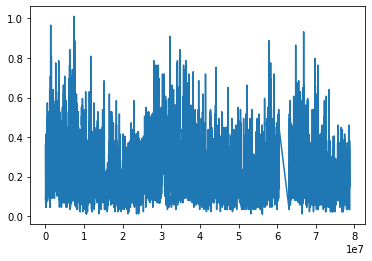

In [18]:
plt.figure()
plt.plot(t, x)

In [19]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [20]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (21193, 1)
xt (8555, 1)


In [21]:
mod_quant_preds = 1e9 / rnge * (mods_no2[1:, :] + mods_no2[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [22]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [23]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week
# k.find_fourier_omegas(xt, hard_code=[24, 168, 365.25 * 24 / 12, 24 * 365.25])  # Day, Week, Month, Year

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [24]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.14622578
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.16330667
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.17846452
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.19195862
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   60480

[-0.14622578,
 -0.16330667,
 -0.17846452,
 -0.19195862,
 -0.20494573,
 -0.21668382,
 -0.22796898,
 -0.23865391,
 -0.24870558,
 -0.25887957,
 -0.26911354,
 -0.27915645,
 -0.28883767,
 -0.2981856,
 -0.3077015,
 -0.317564,
 -0.3266137,
 -0.33587047,
 -0.34531367,
 -0.3545945,
 -0.36395264,
 -0.37365934,
 -0.3826951,
 -0.39140433,
 -0.40061465,
 -0.40976086,
 -0.41813138,
 -0.42685857,
 -0.43534508,
 -0.4440948,
 -0.45246235,
 -0.46067336,
 -0.46859348,
 -0.47697896,
 -0.4843307,
 -0.49225664,
 -0.5006206,
 -0.5073744,
 -0.5150044,
 -0.5218804,
 -0.5290782,
 -0.5360775,
 -0.5425927,
 -0.5492602,
 -0.5559229,
 -0.5620205,
 -0.56847197,
 -0.57478154,
 -0.58091086,
 -0.58637,
 -0.5920619,
 -0.59781224,
 -0.60361457,
 -0.60866505,
 -0.6141709,
 -0.61887133,
 -0.6235188,
 -0.6284699,
 -0.6333522,
 -0.6379851,
 -0.64301085,
 -0.6466821,
 -0.6509534,
 -0.65499294,
 -0.6589541,
 -0.66289127,
 -0.666621,
 -0.67040575,
 -0.67391396,
 -0.6776756,
 -0.680946,
 -0.6840618,
 -0.68701994,
 -0.69049907,
 

In [25]:
# params = k.predict(t[:predict_through])
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [26]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [27]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

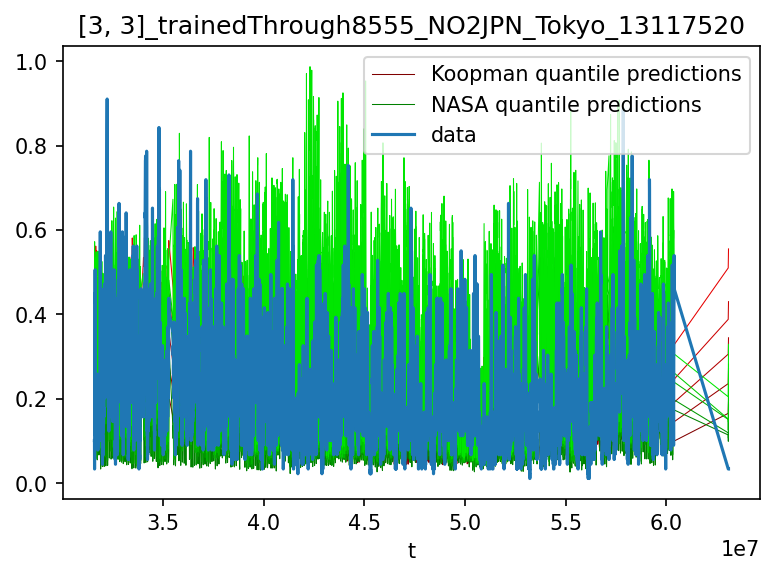

In [28]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [29]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [30]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

In [31]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

In [32]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

In [33]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

<IPython.core.display.Javascript object>

# CHEMICAL O3
## GET CHEMICAL

In [34]:
chemical = "O3"
x = np.expand_dims(obs_o3.conc_obs.values, -1)
t = obs_o3.t.values
print("x", x.shape)
print("t", t.shape)

x (0, 1)
t (0,)


In [35]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [36]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

ValueError: zero-size array to reduction operation maximum which has no identity

In [37]:
plt.figure()
plt.plot(t, x)

<IPython.core.display.Javascript object>

In [38]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [39]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (0, 1)
xt (0, 1)


In [40]:
mod_quant_preds = 1e9 / rnge * (mods_o3[1:, :] + mods_o3[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [41]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [42]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week
# k.find_fourier_omegas(xt, hard_code=[24, 168, 365.25 * 24 / 12, 24 * 365.25])  # Day, Week, Month, Year

ValueError: Invalid number of FFT data points (0) specified.

In [43]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

ZeroDivisionError: integer division or modulo by zero

In [44]:
# params = k.predict(t[:predict_through])
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

IndexError: arrays used as indices must be of integer (or boolean) type

## Get Quantiles

In [45]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [46]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

ValueError: x and y must have same first dimension, but have shapes (7738,) and (0,)

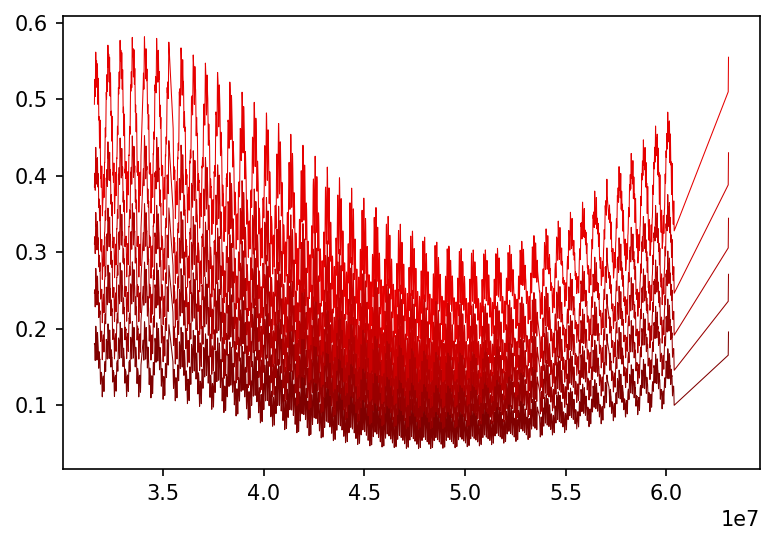

In [47]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [48]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [49]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

IndexError: arrays used as indices must be of integer (or boolean) type

In [50]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

IndexError: arrays used as indices must be of integer (or boolean) type

In [51]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

In [52]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

<IPython.core.display.Javascript object>

# CHEMICAL PM25
## GET CHEMICAL

In [53]:
chemical = "PM25"
x = np.expand_dims(obs_pm25.conc_obs.values, -1)
t = obs_pm25.t.values
print("x", x.shape)
print("t", t.shape)

x (21443, 1)
t (21443,)


In [54]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [55]:
x_original = x
rnge = np.std(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (21443, 1)
t (21443,)


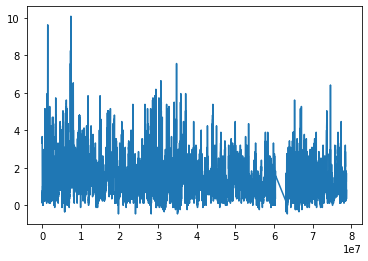

In [56]:
%matplotlib inline
plt.figure()
plt.plot(t, x)

In [57]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [58]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (21443, 1)
xt (8662, 1)


In [59]:
mod_quant_preds = 1 / rnge * (mods_pm25[1:, :] + mods_pm25[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [60]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [61]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week
# k.find_fourier_omegas(xt, hard_code=[24, 168, 365.25 * 24 / 12, 24 * 365.25])  # Day, Week, Month, Year

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [62]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([nan, nan, nan, nan, nan, nan], grad_fn=<MulBackward0>)
Loss:  nan
Final loss: nan


[nan]

In [63]:
# params = k.predict(t[:predict_through])
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [64]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [65]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

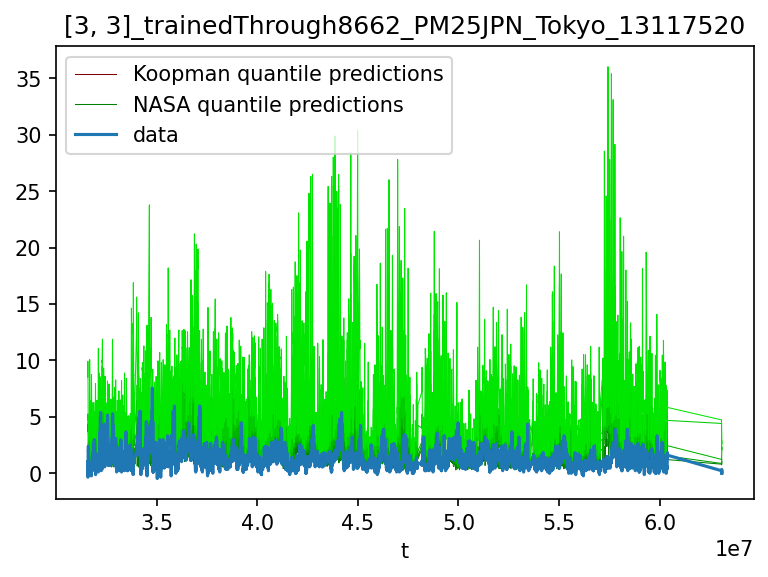

In [66]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [67]:
NASAcomparison[station_name][chemical] = {"koopman": dict(), "NASA": dict()}

In [68]:
NASAcomparison[station_name][chemical]["koopman"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], quant_preds, quantiles)
NASAcomparison[station_name][chemical]["koopman"]["nmb"] = nmb(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mean_hat)
NASAcomparison[station_name][chemical]["koopman"]["correlation"] = correlation(x[koopman_test_idxs, 0], mean_hat[:, 0])

ValueError: array must not contain infs or NaNs

In [69]:
mod_mean = np.mean(mod_quant_preds[mod_test_idxs, :], axis=1)
NASAcomparison[station_name][chemical]["NASA"]["pinball"] = pinball_loss(x[koopman_test_idxs, 0], mod_quant_preds[mod_test_idxs, :], quantiles)
NASAcomparison[station_name][chemical]["NASA"]["nmb"] = nmb(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["nrmse"] = nrmse(x[koopman_test_idxs, 0], mod_mean)
NASAcomparison[station_name][chemical]["NASA"]["correlation"] = correlation(x[koopman_test_idxs, 0], mod_mean)

In [70]:
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}

In [71]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

<IPython.core.display.Javascript object>

In [72]:
with open(".\\atmo_chem\\NASAcomparison.json", "w") as f:
    f.write(json.dumps(NASAcomparison))
NASAcomparison

{'Station0004436': {'NO2': {'koopman': {'pinball': 0.0216650459421217,
    'nmb': -0.017596977006651214,
    'nrmse': 0.33004161332837645,
    'correlation': 0.251969212499101},
   'NASA': {'pinball': 0.040262643344070495,
    'nmb': 0.6470942073080698,
    'nrmse': 0.5518554636262638,
    'correlation': 0.172517941537615}},
  'O3': {'koopman': {'pinball': 0.04777866948338766,
    'nmb': 0.06474254457134208,
    'nrmse': 0.35243628643838604,
    'correlation': 0.539279853696767},
   'NASA': {'pinball': 0.05788467546041508,
    'nmb': 0.012311903988272801,
    'nrmse': 0.30525200611129194,
    'correlation': 0.524858715375988}},
  'PM25': {'koopman': {'pinball': 0.09319310875267511,
    'nmb': 0.21195505075221202,
    'nrmse': 0.44498575082134145,
    'correlation': 0.02003910907627966},
   'NASA': {'pinball': 0.5031557277953198,
    'nmb': 3.4309453304887714,
    'nrmse': 2.1170423517965777,
    'correlation': 0.2794910966870648}}},
 'Station0000036': {'NO2': {'koopman': {}, 'NASA': {}